<small><i>(c) October 2016 - This notebook was created by [Oriol Pujol Vila](http://www.maia.ub.es/~oriol).</i></small>

# Mixture Models

Many clustering algorithms are related to inferences of multiple gaussians. In this notebook we will work on some approaches regarding clustering starting with a very classic algorithm **k-means** and we will move from that to more interesting techniques to finally move towards Gaussian mixture models.

## 1. About clustering

Partition unlabeled examples into disjoint subsets of clusters, such that:

+ Examples within a cluster are similar (high intra-class similarity)
+ Examples in different clusters are different (low inter-class similarity)

It can help in discovering new categories in an unsupervised manner (no sample category labels provided).

This task has many application in different domains:

+ Group genes that perform the same function
+ Group individuals that has similar political view
+ Categorize documents of similar topics
+ Market segmentation/ building customer profiles for market analysis
+ Social network analysis
+ Astronomical data analysis
+ Compression 
+ Detection of near duplicates
+ Grouping related stock quotes for investment portfolio management
+ Building a code book of prototype samples for supervised learning algorithms

### Important questions in clustering

+ What is a natural grouping among these objects? 
    + Definition of "groupness"
    + What makes objects “related”? 
    + Definition of "similarity/distance"
+ Representation for objects 
    + Vector space? Normalization?
+ How many clusters?
    + Fixed a priori?
    + Completely data driven?
    + Avoid “trivial” clusters - too large or small

## 1.1 K-means algorithm

The K-means algorithm looks at the problem of identifying groups, or clusters of data points in a multidimensional space. Our goal is to partition the space in $K$ clusters. In k-means, the clusters are represented by $k$ prototypes $\{m^{(k)}\}$. We may think about these prototypes as the centers of the clusters. 

Our goal is twofold:
+ Find the values of the prototypes.
+ Find the assignment of the points in the space given the prototypes.

Let us model these two quantities. First, let us model the assignment rule by defining a `responsibility` variable, that tells us that a point belongs to a certain cluster,


$$r_n^{(k)} = \left\{\begin{align}1 & \quad \text{if}\; x_n\in c_k\\ 0 &\quad \text{otherwise} \end{align}\right.$$


Now we can define the *objective function*. In k-means this is a measure that models the fact that elements in one cluster have small intra-cluster distance compared with the distance to elements in the rest of the clusters. We can formulate the objective as 

$$\underset{r,m}{\text{minimize}}\quad \sum_{k=1}^K\sum_{i=1}^N r_i^{(k)}\|x_i-m^{(k)}\|^2$$

The solution of this problem can be done by iterating two steps, similar to a block coordinate optimization or an alternating projections technique, in which you solve first for one while keeping the other fixed, and then you optimize the other based on the former solution. 

In this case we may choose an initial value of the prototypes $\{m^{(k)}\}$ and then alternate the following steps:
+ **Step E:** We minimize the objective with respect to $r_i^{(k)}$ keeping the values of the prototypes fixed.
+ **Step M:** We minimize the objective with respect to $\{m^{(k)}\}$ keeping the values of the responsibilities fixed.

This technique as explained in this context is a protoform of a more general approach commonly called **Expectation Maximization (EM)**, where the expectation step **E** and the maximization step **M** alternates.

In the context of k-means, solving the **E** step corresponds to assign the points to the nearest prototype, thus

$$r_n^{(k)} = \left\{\begin{align}1 & \quad \text{if}\; k = \arg\min_j \|x_n-m^{(j)}\|^2\\ 0 &\quad \text{otherwise} \end{align}\right.$$

The **M** step correspondes to optimizing with respect to $\{m^{(k)}\}$, if we take derivatives and set them to zero, we obtain
$$-2\sum_{i=1}^N  r_i^{(k)}(x_i-m^{(k)})=0$$
which gives

$$m^{(k)} = \frac{\sum_n r_n^{(k)}x_n}{\sum_i r_i^{(k)}}$$

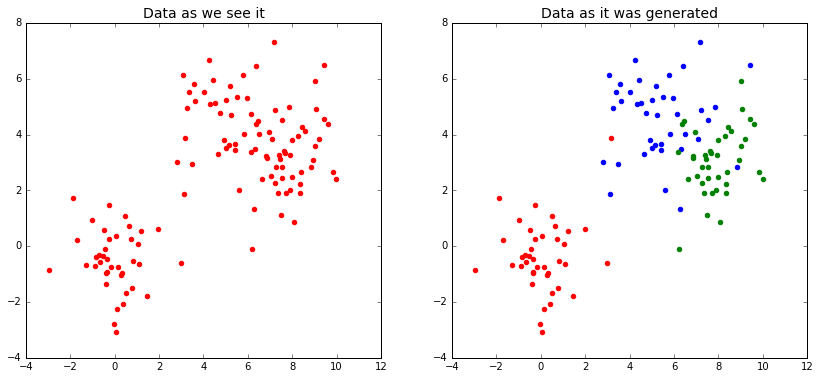

In [14]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
#Create some data
MAXN=40
X = np.concatenate([1.25*np.random.randn(MAXN,2),5+1.5*np.random.randn(MAXN,2)]) 
X = np.concatenate([X,[8,3]+1*np.random.randn(MAXN,2)])

#Just for visualization purposes
y = np.concatenate([np.ones((MAXN,1)),2*np.ones((MAXN,1))])
y = np.concatenate([y,3*np.ones((MAXN,1))])

plt.subplot(1,2,1)
plt.scatter(X[:,0],X[:,1],color='r')
plt.title('Data as we see it', size=14)

plt.subplot(1,2,2)
plt.scatter(X[(y==1).ravel(),0],X[(y==1).ravel(),1],color='r')
plt.scatter(X[(y==2).ravel(),0],X[(y==2).ravel(),1],color='b')
plt.scatter(X[(y==3).ravel(),0],X[(y==3).ravel(),1],color='g')
plt.title('Data as it was generated',size=14)
fig=plt.gcf()
fig.set_size_inches((14,6))

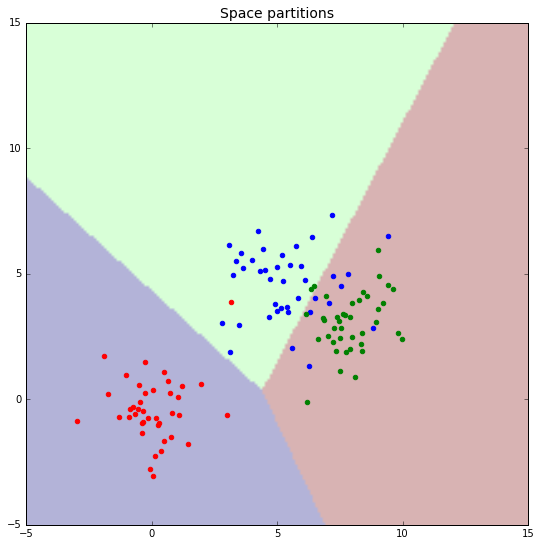

In [15]:
from sklearn import cluster

K=3
clf = cluster.KMeans(init='random', n_clusters=K, random_state=0)
clf.fit(X)

plt.scatter(X[(y==1).ravel(),0],X[(y==1).ravel(),1],color='r')
plt.scatter(X[(y==2).ravel(),0],X[(y==2).ravel(),1],color='b')
plt.scatter(X[(y==3).ravel(),0],X[(y==3).ravel(),1],color='g')

x = np.linspace(-5,15,200)
XX,YY = np.meshgrid(x,x)
sz=XX.shape
data=np.c_[XX.ravel(),YY.ravel()]

Z=clf.predict(data)
plt.imshow(Z.reshape(sz), interpolation='bilinear', origin='lower', extent=(-5,15,-5,15),alpha=0.3, vmin=0, vmax=K-1)
plt.title('Space partitions', size=14)
fig = plt.gcf()
fig.set_size_inches((9,9))

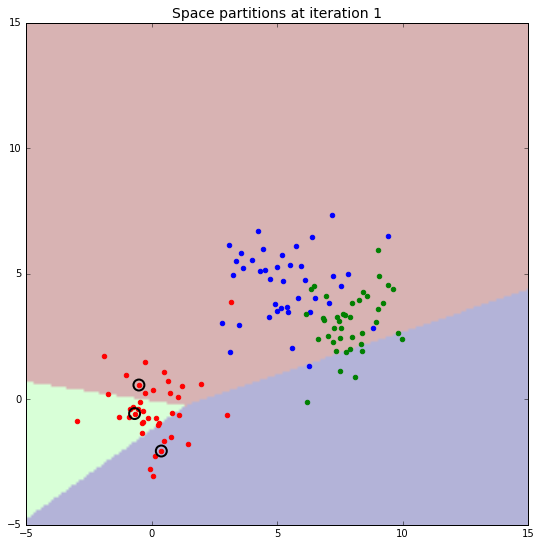

In [16]:
from sklearn import cluster
from scipy.spatial.distance import cdist
K=3

#Select the three centroids: the first three elements of the data
C=X[:3,:]

plt.scatter(X[(y==1).ravel(),0],X[(y==1).ravel(),1],color='r')
plt.scatter(X[(y==2).ravel(),0],X[(y==2).ravel(),1],color='b')
plt.scatter(X[(y==3).ravel(),0],X[(y==3).ravel(),1],color='g')
plt.scatter(C[:,0],C[:,1],s=120, 
           facecolors='none', 
           linewidths=2,
           zorder=10)

x = np.linspace(-5,15,200)
XX,YY = np.meshgrid(x,x)
sz=XX.shape
data=np.c_[XX.ravel(),YY.ravel()]
Y = cdist(data, C, 'euclidean')
Z = np.argmin(Y,axis=1)
plt.imshow(Z.reshape(sz), interpolation='bilinear', origin='lower', extent=(-5,15,-5,15),alpha=0.3, vmin=0, vmax=K-1)
plt.title('Space partitions at iteration 1', size=14)
fig = plt.gcf()
fig.set_size_inches((9,9))

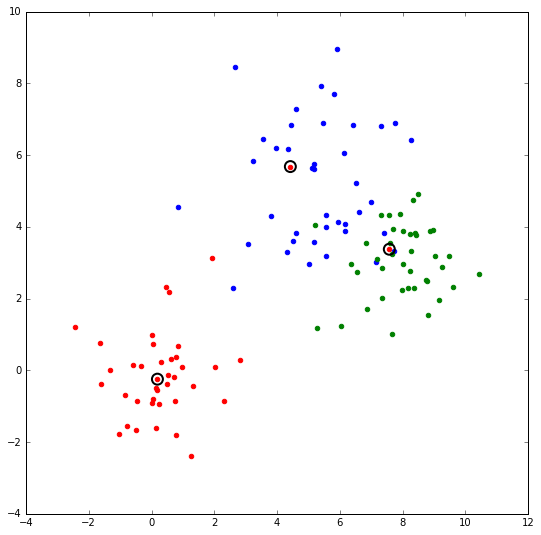

In [24]:
#Compute membership for next iteration
Y = cdist(X, C, 'seuclidean')
y_pred = np.argmin(Y,axis=1)

#Update centroids
for i in xrange(K):
    C[i,:]=np.mean(X[y_pred==i,:],axis=0)

plt.scatter(X[(y==1).ravel(),0],X[(y==1).ravel(),1],color='r')
plt.scatter(X[(y==2).ravel(),0],X[(y==2).ravel(),1],color='b')
plt.scatter(X[(y==3).ravel(),0],X[(y==3).ravel(),1],color='g')
plt.scatter(C[:,0],C[:,1],s=120, 
           facecolors='none', 
           linewidths=2,
           zorder=10)
fig = plt.gcf()
fig.set_size_inches((9,9))

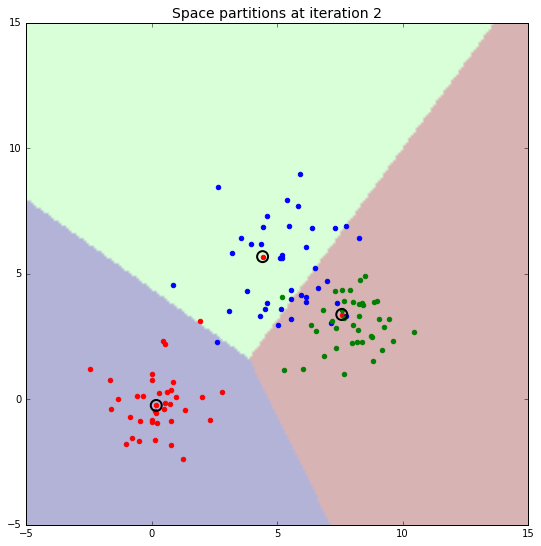

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import numpy as np
#And the new area of influence
plt.scatter(X[(y==1).ravel(),0],X[(y==1).ravel(),1],color='r')
plt.scatter(X[(y==2).ravel(),0],X[(y==2).ravel(),1],color='b')
plt.scatter(X[(y==3).ravel(),0],X[(y==3).ravel(),1],color='g')
plt.scatter(C[:,0],C[:,1],s=120, 
           facecolors='none', 
           linewidths=2,
           zorder=10)
x = np.linspace(-5,15,200)
XX,YY = np.meshgrid(x,x)
sz=XX.shape
data=np.c_[XX.ravel(),YY.ravel()]
Y = cdist(data, C, 'euclidean')
Z = np.argmin(Y,axis=1)
plt.imshow(Z.reshape(sz), interpolation='bilinear', origin='lower', extent=(-5,15,-5,15),alpha=0.3, vmin=0, vmax=K-1)
plt.title('Space partitions at iteration 2', size=14)
fig = plt.gcf()
fig.set_size_inches((9,9))

### Another problem

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import numpy as np

X = np.concatenate([1.25*np.random.randn(MAXN,2),5+1.5*np.random.randn(MAXN,2)]) 
X = np.concatenate([X,[8,3]+1*np.random.randn(MAXN,2)])

K =3
C=X[0:K,:]

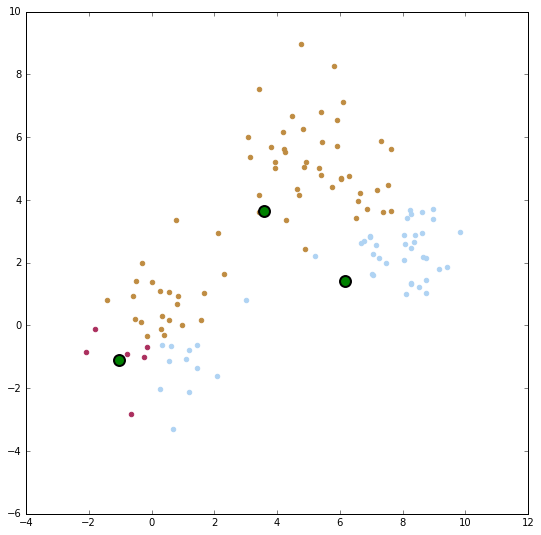

In [27]:
def kmeans_iter(X,C):
    #Compute membership for next iteration
    Y = cdist(X, C, 'seuclidean')
    y_pred = np.argmin(Y,axis=1)

    #Update centroids
    for i in xrange(K):
        C[i,:]=np.mean(X[y_pred==i,:],axis=0)
    return C,y_pred

        

C,y_pred = kmeans_iter(X,C)
for label in np.unique(y_pred):
    plt.scatter(X[(y_pred==label).ravel(),0],X[(y_pred==label).ravel(),1],color=[np.random.rand(),np.random.rand(),np.random.rand()])

    
plt.scatter(C[:,0],C[:,1],s=120, 
           facecolors='green', 
           linewidths=2,
           zorder=10)
fig = plt.gcf()
fig.set_size_inches((9,9))

Lets run some times and see how we get different results. Let us move to a different dataset

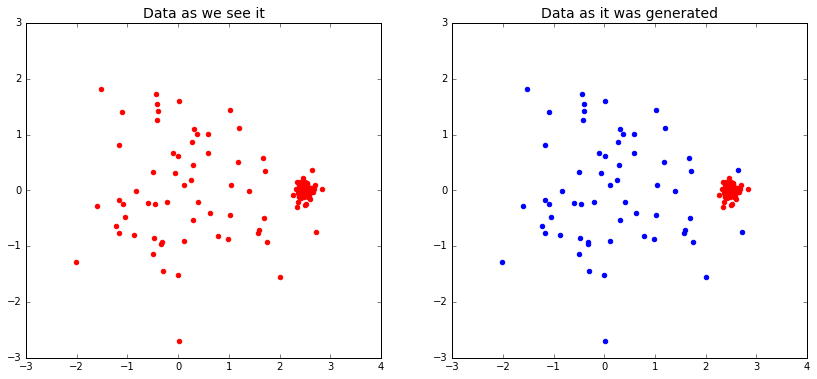

In [28]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
#Create some data
MAXN=60
X = np.concatenate([[2.5,0]+0.1*np.random.randn(MAXN,2)]) 
X = np.concatenate([X,[0,0]+1*np.random.randn(MAXN,2)])

#Just for visualization purposes
y = np.concatenate([np.ones((MAXN,1))])
y = np.concatenate([y,2*np.ones((MAXN,1))])

plt.subplot(1,2,1)
plt.scatter(X[:,0],X[:,1],color='r')
plt.title('Data as we see it', size=14)

plt.subplot(1,2,2)
plt.scatter(X[(y==1).ravel(),0],X[(y==1).ravel(),1],color='r')
plt.scatter(X[(y==2).ravel(),0],X[(y==2).ravel(),1],color='b')
plt.title('Data as it was generated',size=14)
fig=plt.gcf()
fig.set_size_inches((14,6))

[0 1]


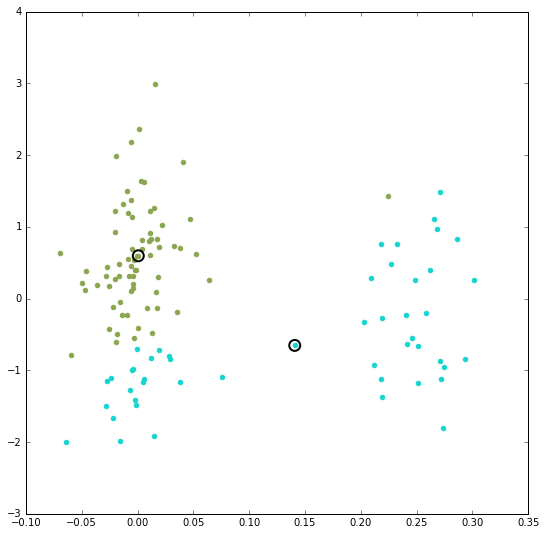

In [44]:
K =2
C=X[0:K,:]
C,y_pred = kmeans_iter(X,C)
print np.unique(y_pred)
for label in np.unique(y_pred):
    plt.scatter(X[(y_pred==label).ravel(),0],X[(y_pred==label).ravel(),1],color=[np.random.rand(),np.random.rand(),np.random.rand()])

    
plt.scatter(C[:,0],C[:,1],s=120, 
           facecolors='none', 
           linewidths=2,
           zorder=10)
fig = plt.gcf()
fig.set_size_inches((9,9))

[0 1]


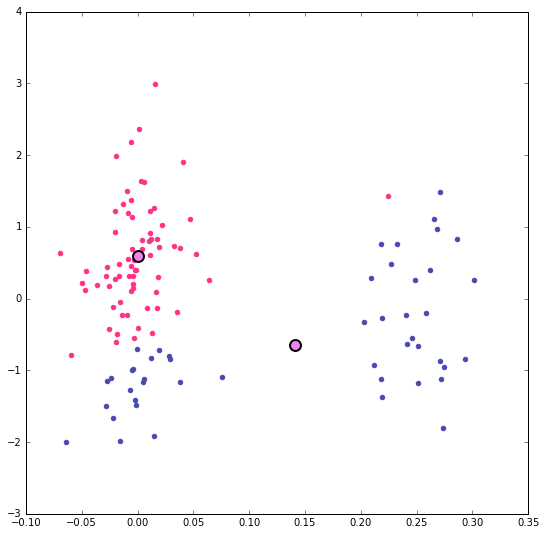

In [46]:

def kmeans_iter(X,C):
    #Compute membership for next iteration
    Y = cdist(X, C, 'seuclidean')
    y_pred = np.argmin(Y,axis=1)

    #Update centroids
    for i in xrange(K):
        C[i,:]=np.mean(X[y_pred==i,:],axis=0)
    return C,y_pred

        

C,y_pred = kmeans_iter(X,C)
print np.unique(y_pred)
for label in np.unique(y_pred):
    plt.scatter(X[(y_pred==label).ravel(),0],X[(y_pred==label).ravel(),1],color=[np.random.rand(),np.random.rand(),np.random.rand()])

    
plt.scatter(C[:,0],C[:,1],s=120, 
           facecolors='violet', 
           linewidths=2,
           zorder=10)
fig = plt.gcf()
fig.set_size_inches((9,9))

We don't quite like this one.

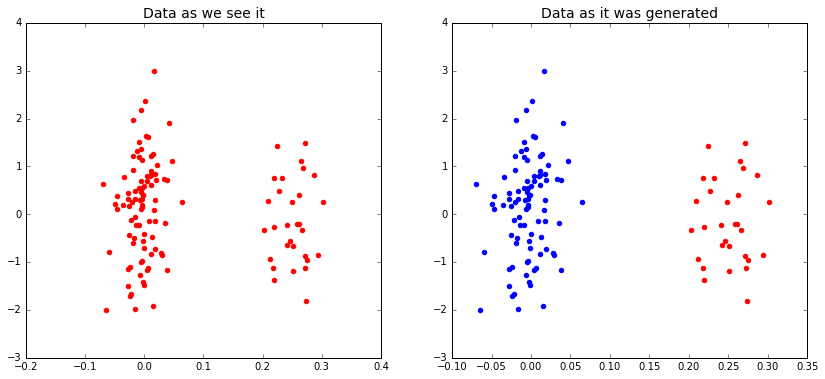

In [31]:
import numpy as np
import matplotlib.pyplot as plt
#Create some data
MAXN1=30
MAXN=90
X = np.concatenate([[0.25,0]+[0.025,1.]*np.random.randn(MAXN1,2)]) 
X = np.concatenate([X,[0,0]+[0.025,1.]*np.random.randn(MAXN,2)])

#Just for visualization purposes
y = np.concatenate([np.ones((MAXN1,1))])
y = np.concatenate([y,2*np.ones((MAXN,1))])

plt.subplot(1,2,1)
plt.scatter(X[:,0],X[:,1],color='r')
plt.title('Data as we see it', size=14)

plt.subplot(1,2,2)
plt.scatter(X[(y==1).ravel(),0],X[(y==1).ravel(),1],color='r')
plt.scatter(X[(y==2).ravel(),0],X[(y==2).ravel(),1],color='b')
plt.title('Data as it was generated',size=14)
fig=plt.gcf()
fig.set_size_inches((14,6))

In [32]:
K =2
C=X[51:51+K,:]

[0 1]


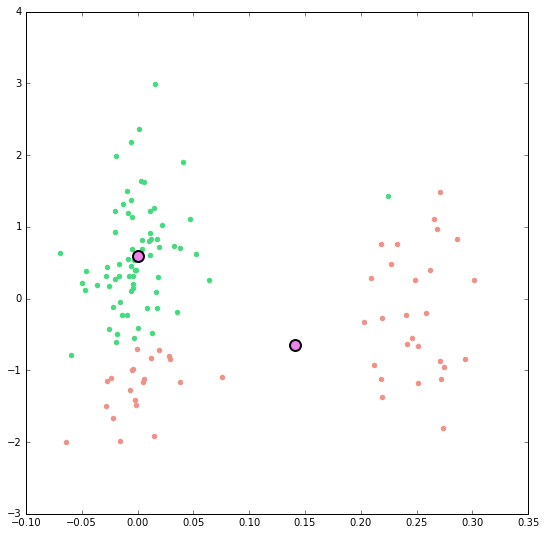

In [47]:
def kmeans_iter(X,C):
    #Compute membership for next iteration
    Y = cdist(X, C, 'seuclidean')
    y_pred = np.argmin(Y,axis=1)

    #Update centroids
    for i in xrange(K):
        C[i,:]=np.mean(X[y_pred==i,:],axis=0)
    return C,y_pred

        

C,y_pred = kmeans_iter(X,C)
print np.unique(y_pred)
for label in np.unique(y_pred):
    plt.scatter(X[(y_pred==label).ravel(),0],X[(y_pred==label).ravel(),1],color=[np.random.rand(),np.random.rand(),np.random.rand()])

    
plt.scatter(C[:,0],C[:,1],s=120, 
           facecolors='violet', 
           linewidths=2,
           zorder=10)
fig = plt.gcf()
fig.set_size_inches((9,9))

<div class = "alert alert-success" style="border-radius:10px">**EXERCISE: ** How we can improve this algorithm?</div>

## 1.2 Soft k-means
We set a stiffness parameter $\beta$ and we change the assignment rule considering the similarity to each of the means. Observe that the similarity is now defined with respect to all possible means, this is each point resebles something to each mean. This will mean that all data contribute to the assignment.

$$r_k^{(n)} = \frac{e^{-\beta d(x^{(n)},m^{(k)})}}{\sum_i e^{-\beta d(x_n,m_i)}}$$

The sum of the responsibilities of the k means for each point adds to one.

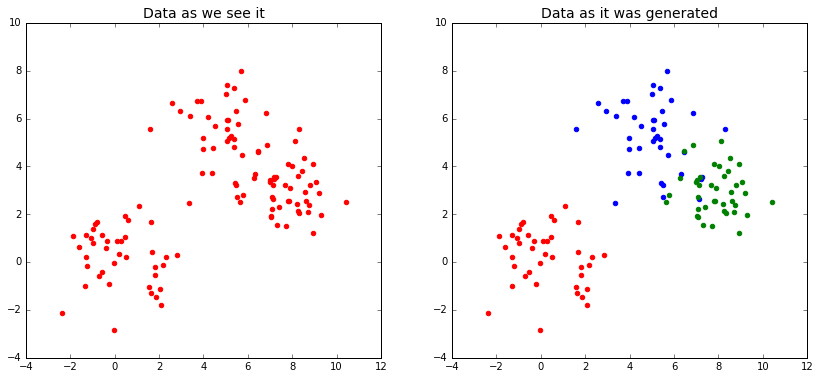

In [82]:
import numpy as np
import matplotlib.pyplot as plt
#Create some data
MAXN=40
X = np.concatenate([1.25*np.random.randn(MAXN,2),5+1.5*np.random.randn(MAXN,2)]) 
X = np.concatenate([X,[8,3]+1*np.random.randn(MAXN,2)])

#Just for visualization purposes
y = np.concatenate([np.ones((MAXN,1)),2*np.ones((MAXN,1))])
y = np.concatenate([y,3*np.ones((MAXN,1))])

plt.subplot(1,2,1)
plt.scatter(X[:,0],X[:,1],color='r')
plt.title('Data as we see it', size=14)

plt.subplot(1,2,2)
plt.scatter(X[(y==1).ravel(),0],X[(y==1).ravel(),1],color='r')
plt.scatter(X[(y==2).ravel(),0],X[(y==2).ravel(),1],color='b')
plt.scatter(X[(y==3).ravel(),0],X[(y==3).ravel(),1],color='g')
plt.title('Data as it was generated',size=14)
fig=plt.gcf()
fig.set_size_inches((14,6))

In [83]:
#X

[[-0.41351689  0.57485022]
 [ 1.87511878 -1.45072984]
 [-0.58728192  1.12462383]]


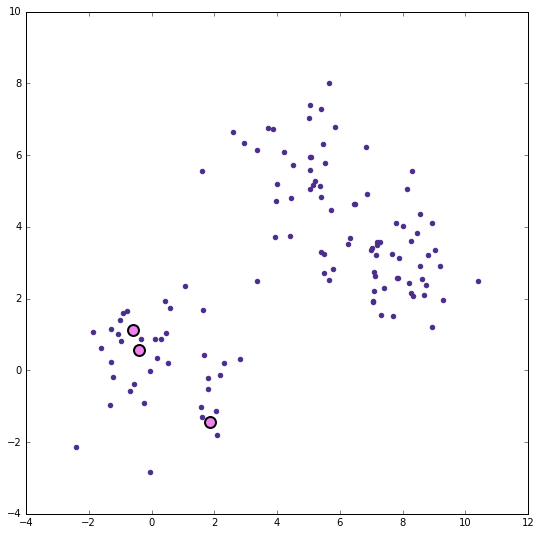

In [84]:
K =3
C=X[0:K,:].copy()
print C
for label in np.unique(y_pred):
    plt.scatter(X[(y_pred==label).ravel(),0],X[(y_pred==label).ravel(),1],\
                color=[np.random.rand(),np.random.rand(),np.random.rand()])

    
plt.scatter(C[:,0],C[:,1],s=120, 
           facecolors='violet', 
           linewidths=2,
           zorder=10)
fig = plt.gcf()
fig.set_size_inches((9,9))

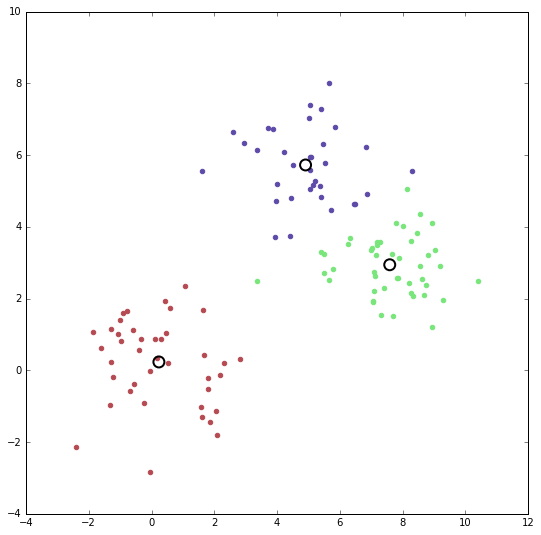

In [85]:
def soft_kmeans_iter(X,C,beta):
    #Compute membership for next iteration
    d = cdist(X, C, 'seuclidean')
    r = np.exp(-beta*d)
    r = r/(np.dot(np.sum(r, axis=1)[:,np.newaxis],np.ones((1,K)))+1e-16)
    #Update centroids
    for i in xrange(K):
        for dim in xrange(C.shape[1]):
            C[i,dim] = np.sum(X[:,dim]*r[:,i])/(np.sum(r[:,i])+1e-16)
    return C,r

        
beta=10
for iter in xrange(100):
    C,r = soft_kmeans_iter(X,C,beta)
y_pred = np.argmax(r,axis=1)
for label in np.unique(y_pred):
    plt.scatter(X[(y_pred==label).ravel(),0],X[(y_pred==label).ravel(),1],color=[np.random.rand(),np.random.rand(),np.random.rand()])

    
plt.scatter(C[:,0],C[:,1],s=max(1200/beta,120), 
           facecolors='none', 
           linewidths=2,
           zorder=10)
fig = plt.gcf()
fig.set_size_inches((9,9))

In [86]:
C

array([[ 0.23577935,  0.23314977],
       [ 7.59016787,  2.942544  ],
       [ 4.90837025,  5.72446757]])

<div class = "alert alert-success" style = "border-radius:10px">**EXERCISE: ** Change the parameter $K$, and the parameter $\beta$. Describe what happens. </div>

If $\beta$ is small, you include more samples. So you may get less clusters.
If $\beta$ is big ...


### If you set $\beta$ to 0.1, you will get only one cluster

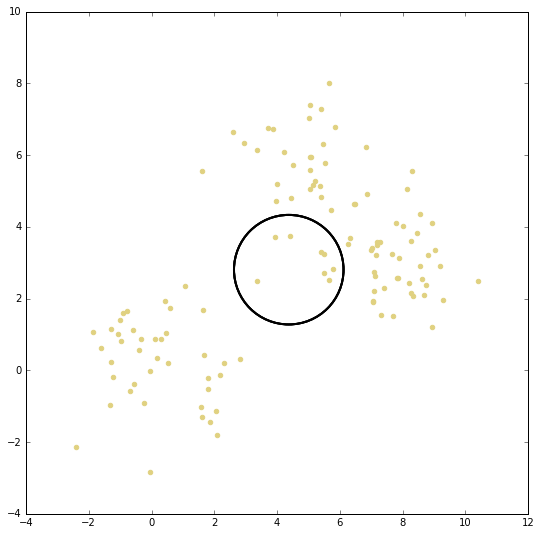

In [87]:
def soft_kmeans_iter(X,C,beta):
    #Compute membership for next iteration
    d = cdist(X, C, 'seuclidean')
    r = np.exp(-beta*d)
    r = r/(np.dot(np.sum(r, axis=1)[:,np.newaxis],np.ones((1,K)))+1e-16)
    #Update centroids
    for i in xrange(K):
        for dim in xrange(C.shape[1]):
            C[i,dim] = np.sum(X[:,dim]*r[:,i])/(np.sum(r[:,i])+1e-16)
    return C,r

        
beta=0.1
for iter in xrange(100):
    C,r = soft_kmeans_iter(X,C,beta)
y_pred = np.argmax(r,axis=1)
for label in np.unique(y_pred):
    plt.scatter(X[(y_pred==label).ravel(),0],X[(y_pred==label).ravel(),1],color=[np.random.rand(),np.random.rand(),np.random.rand()])

    
plt.scatter(C[:,0],C[:,1],s=max(1200/beta,120), 
           facecolors='none', 
           linewidths=2,
           zorder=10)
fig = plt.gcf()
fig.set_size_inches((9,9))

We can think of $\beta = 1/\sigma^2$

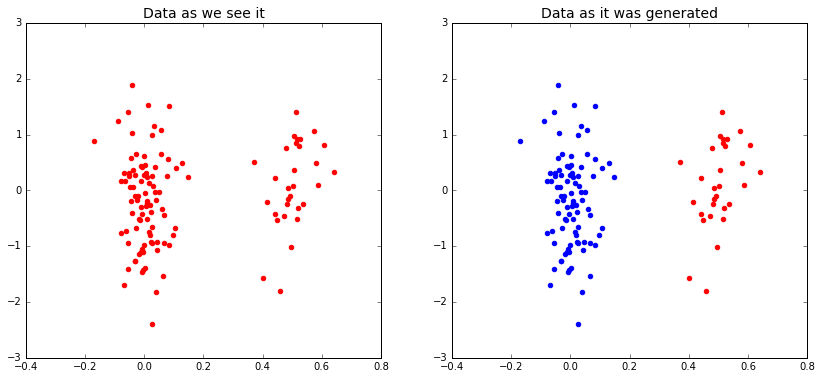

In [120]:
import numpy as np
import matplotlib.pyplot as plt
#Create some data
MAXN1=30
MAXN=90
X = np.concatenate([[0.5,0]+[0.05,1.]*np.random.randn(MAXN1,2)]) 
X = np.concatenate([X,[0,0]+[0.05,1.]*np.random.randn(MAXN,2)])

#Just for visualization purposes
y = np.concatenate([np.ones((MAXN1,1))])
y = np.concatenate([y,2*np.ones((MAXN,1))])

plt.subplot(1,2,1)
plt.scatter(X[:,0],X[:,1],color='r')
plt.title('Data as we see it', size=14)

plt.subplot(1,2,2)
plt.scatter(X[(y==1).ravel(),0],X[(y==1).ravel(),1],color='r')
plt.scatter(X[(y==2).ravel(),0],X[(y==2).ravel(),1],color='b')
plt.title('Data as it was generated',size=14)
fig=plt.gcf()
fig.set_size_inches((14,6))

[[ 0.58784281  0.1044559 ]
 [ 0.60648013  0.81999096]]


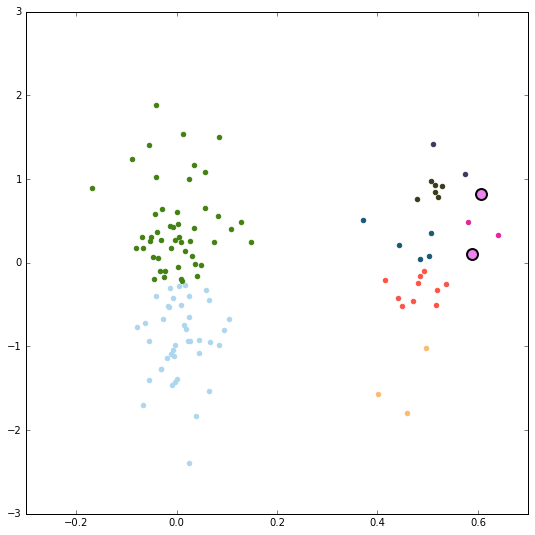

In [134]:
K =2
C=X[0:K,:].copy()
print C
for label in np.unique(y_pred):
    plt.scatter(X[(y_pred==label).ravel(),0],X[(y_pred==label).ravel(),1],color=[np.random.rand(),np.random.rand(),np.random.rand()])

    
plt.scatter(C[:,0],C[:,1],s=120, 
           facecolors='violet', 
           linewidths=2,
           zorder=10)
fig = plt.gcf()
fig.set_size_inches((9,9))

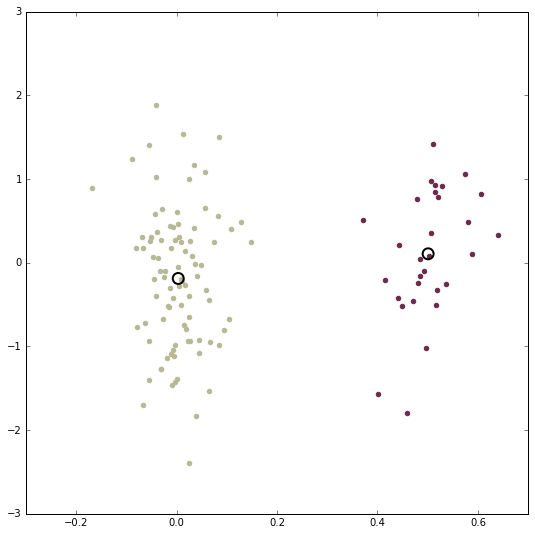

In [137]:
def soft_kmeans_iter(X,C,beta):
    #Compute membership for next iteration
    d = cdist(X, C, 'seuclidean')
    r = np.exp(-beta*d)
    r = r/(np.dot(np.sum(r, axis=1)[:,np.newaxis],np.ones((1,K)))+1e-16)
    #Update centroids
    for i in xrange(K):
        for dim in xrange(C.shape[1]):
            C[i,dim] = np.sum(X[:,dim]*r[:,i])/(np.sum(r[:,i])+1e-16)
    return C,r

        
beta=10
for iter in xrange(1000):
    C,r = soft_kmeans_iter(X,C,beta)
y_pred = np.argmax(r,axis=1)
for label in np.unique(y_pred):
    plt.scatter(X[(y_pred==label).ravel(),0],X[(y_pred==label).ravel(),1],\
                color=[np.random.rand(),np.random.rand(),np.random.rand()])

    
plt.scatter(C[:,0],C[:,1],s=max(1200/beta,120), 
           facecolors='none', 
           linewidths=2,
           zorder=10)
fig = plt.gcf()
fig.set_size_inches((9,9))

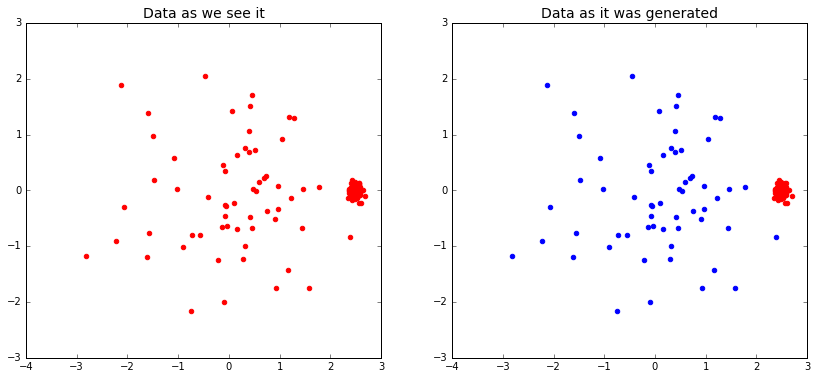

In [114]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
#Create some data
MAXN=60
X = np.concatenate([[2.5,0]+0.1*np.random.randn(MAXN,2)]) 
X = np.concatenate([X,[0,0]+1*np.random.randn(MAXN,2)])

#Just for visualization purposes
y = np.concatenate([np.ones((MAXN,1))])
y = np.concatenate([y,2*np.ones((MAXN,1))])

plt.subplot(1,2,1)
plt.scatter(X[:,0],X[:,1],color='r')
plt.title('Data as we see it', size=14)

plt.subplot(1,2,2)
plt.scatter(X[(y==1).ravel(),0],X[(y==1).ravel(),1],color='r')
plt.scatter(X[(y==2).ravel(),0],X[(y==2).ravel(),1],color='b')
plt.title('Data as it was generated',size=14)
fig=plt.gcf()
fig.set_size_inches((14,6))

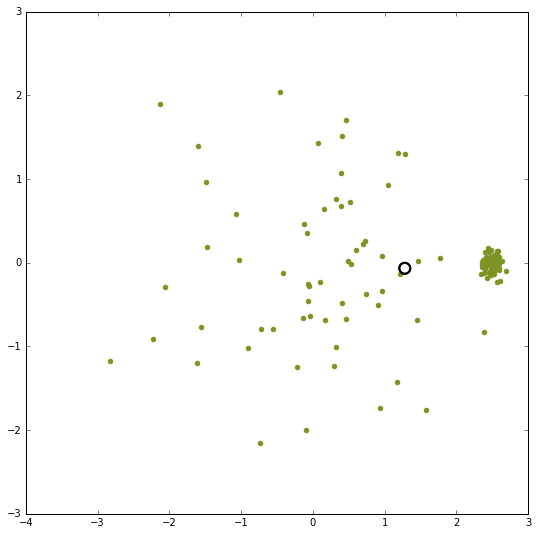

In [119]:
K =2

def soft_kmeans_iter(X,C,beta):
    #Compute membership for next iteration
    d = cdist(X, C, 'seuclidean')
    r = np.exp(-beta*d)
    r = r/(np.dot(np.sum(r, axis=1)[:,np.newaxis],np.ones((1,K)))+1e-16)
    #Update centroids
    for i in xrange(K):
        for dim in xrange(C.shape[1]):
            C[i,dim] = np.sum(X[:,dim]*r[:,i])/(np.sum(r[:,i])+1e-16)
    return C,r

      
beta=10
for iter in xrange(1000):
    C,r = soft_kmeans_iter(X,C,beta)
y_pred = np.argmax(r,axis=1)
for label in np.unique(y_pred):
    plt.scatter(X[(y_pred==label).ravel(),0],X[(y_pred==label).ravel(),1],\
                color=[np.random.rand(),np.random.rand(),np.random.rand()])

    
plt.scatter(C[:,0],C[:,1],s=max(1200/beta,120), 
           facecolors='none', 
           linewidths=2,
           zorder=10)
fig = plt.gcf()
fig.set_size_inches((9,9))

We can change the standard deviation after some iterations.

# 2. Mixtures of Gaussians

From all the former examples we can easily consider a mixture of Gaussian distributions in the following form,

$$p({\bf x}) = \sum\limits_{i=1}^K \pi_k \mathcal{N}({\bf x}|\mu_k,\Sigma_k)$$

Let us derive the mixture of Gaussians from a Bayessian perspective. This will also allow us to introduce our first latent variable and the depiction of joint probability density functions in terms of graphical models.

Let us introduce a K-dimensional binary random variable ${\bf z}$ with a 1-of-K representation ($z_i = 1$ if $i=k$ and $z_i = 0$ if $i\neq k$, with $z_i\in\{0,1\}$). Observe that this random variable has just K possible random states according to which component is nonzero. 

We can define the joint distribution $p({\bf x},{\bf z}) = p({\bf x}|{\bf z})p({\bf z})$. 

<img src = "joint_distribution_pgm.jpg" width=70px>


Let us consider now the probability of $z_k$

$$p(z_k=1) = \pi_k$$

where $0\leq \pi_k \leq 1$, and $\sum_k p(z_k=1) = 1$.

Similarly, 

$$p({\bf x}|z_k=1) = \mathcal{N}({\bf x}|\mu_k,\Sigma_k)$$



Let us compute now the marginal distribution with respect to $x$, i.e. $p({\bf x}) = \sum_z p({\bf x}|{\bf z})p({\bf z})$, this is

$$p({\bf x}) = \sum\limits_{k=1}^K p(z_k=1)p({\bf x}|z_k=1)$$

Note that we are computing this value by considering all states of random variable $z_k$.

$$p({\bf x}) = \sum\limits_{k=1}^K \pi_k\mathcal{N}({\bf x}|\mu_k,\Sigma_k)$$

Great, we have just derived the same as we got at the starting point. But what is this good for? We will see in a minute that this will simplify our computational procedure.

With this representation we can ask about the posterior probability of the assignment state variable, i.e.

$$p(z_k=1|{\bf x}) = \frac{p(z_k=1)p({\bf x}|z_k=1)}{\sum\limits_{i=1}^K p(z_i=1)p({\bf x}|z_i=1)}$$

$$ = \frac{\pi_k\mathcal{N}({\bf x}|\mu_k,\Sigma_k)}{\sum\limits_{i=1}^K \pi_i\mathcal{N}({\bf x}|\mu_i,\Sigma_i)}$$

Observe that this quantity may be considered as the responsibility of that particular Gaussian distribution for generating/"explaining" observation ${\bf x}$.

## Maximum Likelihood

The maximum likelihood objective considering i.i.d. samples corresponds to the problem of 

$$\text{maximize}\quad \prod\limits_{i=1}^N p(x_i|\pi,\mu,\Sigma)$$

we can equivalently maximize the log probability,

$$\text{maximize}\quad \sum\limits_{i=1}^N \ln \{\sum\limits_{k=1}^K \pi_k \mathcal{N}({x_i|\mu_k,\Sigma_k})\}$$

We may use standard gradient based techniques, or use the alternating projections technique. In this case we will use expectation maximization.

Let us write down the conditions for solving that problem: 

- With respect to the means $\mu_k$
$$0 = \sum\limits_{i=1}^N\underset{\gamma(z_n^{(k)})}{\underbrace{\frac{\pi_k\mathcal{N}({\bf x}|\mu_k,\Sigma_k)}{\sum\limits_{i=1}^K \pi_i\mathcal{N}({\bf x}|\mu_i,\Sigma_i)}}} \Sigma^{-1}_k(x_n-\mu_k)$$

if $\Sigma$ is non singular we can rearrange terms to obtain,

$$\mu_k = \frac{1}{N_k} \sum_{n=1}^N \gamma(z_n^{(k)})x_n$$

with 

$$N_k = \sum_{n=1}^N \gamma(z_n^{(k)})$$

with respect to $\Sigma$,

$$\Sigma_k = \frac{1}{N_k}\sum_{n=1}^N \gamma(z_n^{(k)})(x_n-\mu_k)(x_n-\mu_k)^T$$

Finally, with respect to $\pi_k$,

$$\pi_k = \frac{N_k}{N}$$

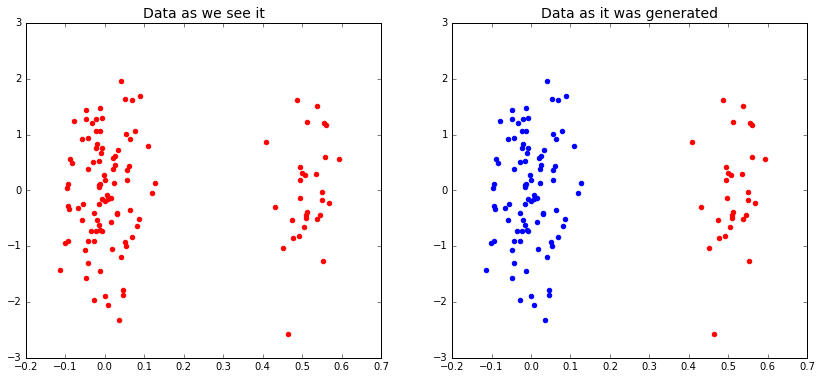

In [138]:
import numpy as np
import matplotlib.pyplot as plt
#Create some data
MAXN1=30
MAXN=90
X = np.concatenate([[0.5,0]+[0.05,1.]*np.random.randn(MAXN1,2)]) 
X = np.concatenate([X,[0,0]+[0.05,1.]*np.random.randn(MAXN,2)])

#Just for visualization purposes
y = np.concatenate([np.ones((MAXN1,1))])
y = np.concatenate([y,2*np.ones((MAXN,1))])

plt.subplot(1,2,1)
plt.scatter(X[:,0],X[:,1],color='r')
plt.title('Data as we see it', size=14)

plt.subplot(1,2,2)
plt.scatter(X[(y==1).ravel(),0],X[(y==1).ravel(),1],color='r')
plt.scatter(X[(y==2).ravel(),0],X[(y==2).ravel(),1],color='b')
plt.title('Data as it was generated',size=14)
fig=plt.gcf()
fig.set_size_inches((14,6))

[[-0.07469221  0.74895234]
 [-0.31720936 -0.8815094 ]]


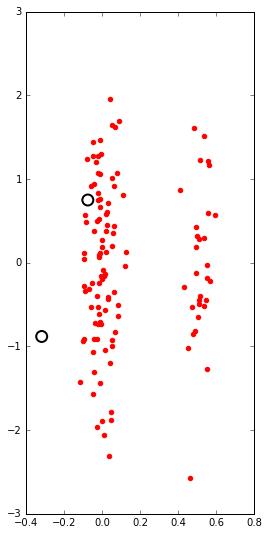

In [141]:
K =2
idx=np.random.randint(0,X.shape[0],K)
C=2*np.random.rand(K,X.shape[1])-1
Sigma=100.*np.ones((K,X.shape[1]))
Pi=(1./K)*np.ones((K,1))
print C
plt.subplot(1,2,1)
plt.scatter(X[:,0],X[:,1],color='r')
plt.scatter(C[:,0],C[:,1],s=120, 
           facecolors='none', 
           linewidths=2,
           zorder=10)
fig = plt.gcf()
fig.set_size_inches((9,9))

[[ 0.00086078  0.39561805]
 [ 0.00140099  0.46673364]] [[ 0.25]
 [ 0.75]]


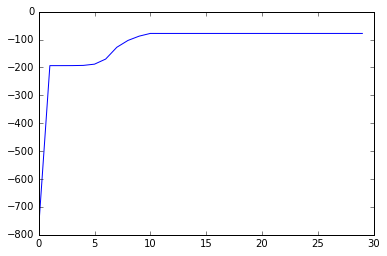

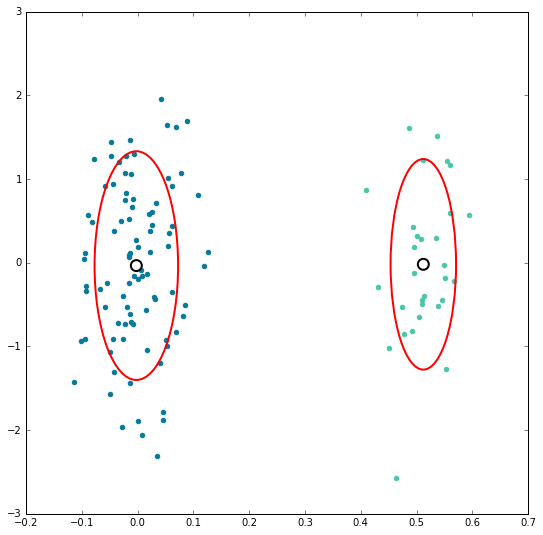

In [142]:
from scipy.stats import multivariate_normal

def define_responsibilities(X,C,Sigma,Pi):
    r = np.zeros((X.shape[0],C.shape[0]))
    for i in xrange(C.shape[0]):
        d = cdist(C[i,:][np.newaxis,:],X,metric='seuclidean',V=Sigma[i,:])**2
        r[:,i]=Pi[i]*np.exp(-0.5*d)/np.prod(np.sqrt(2*np.pi)*Sigma[i,:])
    r = r/np.tile(np.sum(r,axis=1)[:,np.newaxis],(1,C.shape[0]))
    return r

def soft_kmeans2_iter(X,C,Sigma,Pi):
    I=X.shape[1]
    r = define_responsibilities(X,C,Sigma,Pi)
    for k in xrange(C.shape[0]):
        C[k,:]=np.sum((np.tile(r[:,k][:,np.newaxis],(1,C.shape[1]))*X),axis=0)/np.sum(r[:,k])
        Sigma[k,:]= np.sum(np.tile(r[:,k][:,np.newaxis],(1,C.shape[1]))*(X-np.tile(C[k,:][np.newaxis,:],(X.shape[0],1)))**2,axis=0)/(I*np.sum(r[:,k]))
        Pi[k]=np.sum(r[:,k])/np.sum(r) 
    return C,Sigma,Pi

def evaluate_objective(X,C,Sigma,Pi):
    J=0
    for k in xrange(C.shape[1]):
        J += Pi[k]*multivariate_normal.pdf(X, mean=C[k,:], cov=Sigma[k,:])
    return np.sum(np.log(J))
    
conv=[]
for iter in xrange(30):
    conv.append(evaluate_objective(X,C,Sigma,Pi))
    C,Sigma,Pi = soft_kmeans2_iter(X,C,Sigma,Pi)
print Sigma,Pi

plt.figure()
plt.plot(conv)       # cnvrge plot
plt.figure()
r = define_responsibilities(X,C,Sigma,Pi)
y_pred = np.argmax(r,axis=1)
for label in np.unique(y_pred):
    plt.scatter(X[(y_pred==label).ravel(),0],X[(y_pred==label).ravel(),1],color=[np.random.rand(),np.random.rand(),np.random.rand()])

    
plt.scatter(C[:,0],C[:,1],s=120, 
           facecolors='none', 
           linewidths=2,
           zorder=10)

from matplotlib.patches import Ellipse
ax = plt.gca()
ellipse = Ellipse(xy=C[0,:], width=4*np.sqrt(Sigma[0,0]), height=4*np.sqrt(Sigma[0,1]), 
                        edgecolor='r', fc='None', lw=2)
ax.add_patch(ellipse)

ellipse = Ellipse(xy=C[1,:], width=4*np.sqrt(Sigma[1,0]), height=4*np.sqrt(Sigma[1,1]), 
                        edgecolor='r', fc='None', lw=2)
ax.add_patch(ellipse)


fig = plt.gcf()
fig.set_size_inches((9,9))

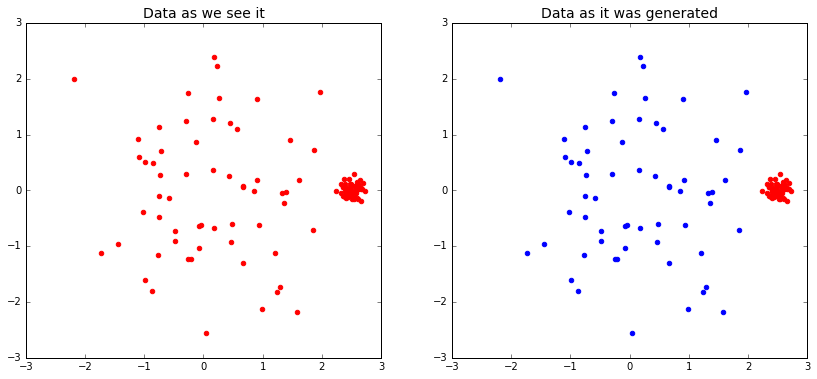

In [96]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
#Create some data
MAXN=60
X = np.concatenate([[2.5,0]+0.1*np.random.randn(MAXN,2)]) 
X = np.concatenate([X,[0,0]+1*np.random.randn(MAXN,2)])

#Just for visualization purposes
y = np.concatenate([np.ones((MAXN,1))])
y = np.concatenate([y,2*np.ones((MAXN,1))])

plt.subplot(1,2,1)
plt.scatter(X[:,0],X[:,1],color='r')
plt.title('Data as we see it', size=14)

plt.subplot(1,2,2)
plt.scatter(X[(y==1).ravel(),0],X[(y==1).ravel(),1],color='r')
plt.scatter(X[(y==2).ravel(),0],X[(y==2).ravel(),1],color='b')
plt.title('Data as it was generated',size=14)
fig=plt.gcf()
fig.set_size_inches((14,6))

[[ 0.53317387  0.66334519]
 [ 0.71008488 -0.90205077]]


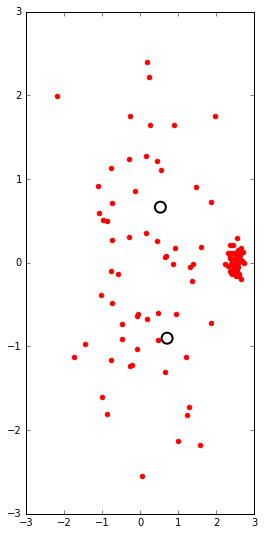

In [97]:
K =2
idx=np.random.randint(0,X.shape[0],K)
C=2*np.random.rand(K,X.shape[1])-1
Sigma=100.*np.ones((K,X.shape[1]))
Pi=(1./K)*np.ones((K,1))
print C
plt.subplot(1,2,1)
plt.scatter(X[:,0],X[:,1],color='r')
plt.scatter(C[:,0],C[:,1],s=120, 
           facecolors='none', 
           linewidths=2,
           zorder=10)
fig = plt.gcf()
fig.set_size_inches((9,9))

[[ 0.46049915  0.67979834]
 [ 0.00551481  0.00515092]] [[ 0.50001228]
 [ 0.49998772]]


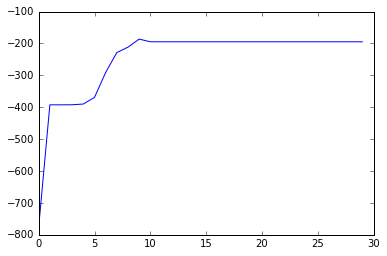

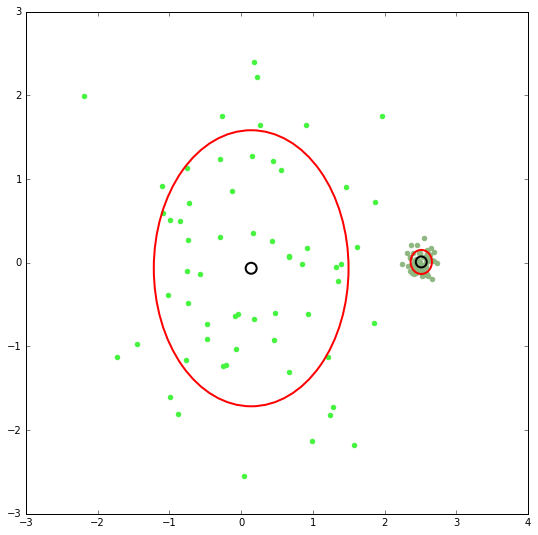

In [98]:
from scipy.stats import multivariate_normal

def define_responsibilities(X,C,Sigma,Pi):
    r = np.zeros((X.shape[0],C.shape[0]))
    for i in xrange(C.shape[0]):
        d = cdist(C[i,:][np.newaxis,:],X,metric='seuclidean',V=Sigma[i,:])**2
        r[:,i]=Pi[i]*np.exp(-0.5*d)/np.prod(np.sqrt(2*np.pi)*Sigma[i,:])
    r = r/np.tile(np.sum(r,axis=1)[:,np.newaxis],(1,C.shape[0]))
    return r

def soft_kmeans2_iter(X,C,Sigma,Pi):
    I=X.shape[1]
    r = define_responsibilities(X,C,Sigma,Pi)
    for k in xrange(C.shape[0]):
        C[k,:]=np.sum((np.tile(r[:,k][:,np.newaxis],(1,C.shape[1]))*X),axis=0)/np.sum(r[:,k])
        Sigma[k,:]= np.sum(np.tile(r[:,k][:,np.newaxis],(1,C.shape[1]))*(X-np.tile(C[k,:][np.newaxis,:],(X.shape[0],1)))**2,axis=0)/(I*np.sum(r[:,k]))
        Pi[k]=np.sum(r[:,k])/np.sum(r) 
    return C,Sigma,Pi

def evaluate_objective(X,C,Sigma,Pi):
    J=0
    for k in xrange(C.shape[1]):
        J += Pi[k]*multivariate_normal.pdf(X, mean=C[k,:], cov=Sigma[k,:])
    return np.sum(np.log(J))
    
conv=[]
for iter in xrange(30):
    conv.append(evaluate_objective(X,C,Sigma,Pi))
    C,Sigma,Pi = soft_kmeans2_iter(X,C,Sigma,Pi)
print Sigma,Pi

plt.figure()
plt.plot(conv)
plt.figure()
r = define_responsibilities(X,C,Sigma,Pi)
y_pred = np.argmax(r,axis=1)
for label in np.unique(y_pred):
    plt.scatter(X[(y_pred==label).ravel(),0],X[(y_pred==label).ravel(),1],color=[np.random.rand(),np.random.rand(),np.random.rand()])

    
plt.scatter(C[:,0],C[:,1],s=120, 
           facecolors='none', 
           linewidths=2,
           zorder=10)

from matplotlib.patches import Ellipse
ax = plt.gca()
ellipse = Ellipse(xy=C[0,:], width=4*np.sqrt(Sigma[0,0]), height=4*np.sqrt(Sigma[0,1]), 
                        edgecolor='r', fc='None', lw=2)
ax.add_patch(ellipse)

ellipse = Ellipse(xy=C[1,:], width=4*np.sqrt(Sigma[1,0]), height=4*np.sqrt(Sigma[1,1]), 
                        edgecolor='r', fc='None', lw=2)
ax.add_patch(ellipse)


fig = plt.gcf()
fig.set_size_inches((9,9))

<div class = "alert alert-success">**EXERCISE: ** Create a new data set with the goal of hindering the learning process and check the behavior of the method.</div>